In [1]:
import h5py
import numpy as np
import tensorflow as tf
import pickle
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import clone_model
import pathlib
from tqdm import tqdm
import sys
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
attack_vector='cache' #network
machine_setting='static_browser_version'#'dynamic_browser_version'

root_path=f'/content/drive/MyDrive/Colab Notebooks/concept-drift-online'
data_path=f'{root_path}/data/{machine_setting}/{attack_vector}'
model_0_train_path=f'2021_08_27/train.h5'


In [ ]:
os.getcwd()

'/content'

In [ ]:
sys.path.append(str(root_path)) # Add the directory to the path
from utils import prepare_hdf5_data,get_data_paths_ordered

In [ ]:

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
model_path=f'{data_path}/models/cnn_lstm.keras'
le_dir=f'{data_path}/models/label_encoder_100.pkl'
model0 = tf.keras.models.load_model(model_path)
with open(le_dir, 'rb') as f:
    le = pickle.load(f)

In [ ]:
ordered_paths=get_data_paths_ordered(data_path)

In [ ]:
RANDOM_SEED = 42

def standartize(curr_input):
    mean = tf.math.reduce_mean(curr_input)
    std = tf.math.reduce_std(curr_input) + 0.0001
    return (curr_input - mean) / std

def predict_on_hdf5_with_cache_noise(test_path, model, label_encoder, noise_std, batch_size=32):
    # Open the HDF5 file for reading
    with h5py.File(test_path, 'r') as hdf:
        # Load the features and labels
        X_test = hdf[f'vector'][:]
        y_test = label_encoder.transform((hdf[f'site_name'][:]).reshape(-1,1)).toarray()

        rng = np.random.default_rng(RANDOM_SEED)
        # abs on normal distribution, always positive
        noise = np.abs(rng.normal(0, noise_std, X_test.shape))
        X_test = X_test + noise

        # Create TensorFlow Dataset objects for efficient batch processing
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(lambda x, y: (standartize(x), y)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Evaluate the model on the test dataset
        res = model.predict(test_dataset)
        return res

In [ ]:
batch=256
max_epochs=20
n_incremental_samples_per_website=10

results={}
for path in tqdm(ordered_paths):
    curr_date_i=path.stem
    test_path_i = (path/'test.h5').as_posix()
    pred_i=predict_on_hdf5_with_cache_noise(test_path_i, model0, le, 0, batch_size=32)
    with h5py.File(test_path_i, 'r') as hdf:
      y_testi = le.transform((hdf[f'site_name'][:]).reshape(-1,1)).toarray()
    acci=(y_testi.argmax(axis=1)==pred_i.argmax(axis=1)).mean()
    results.update({curr_date_i:acci})
    print(f'accuracy: {acci}')

  0%|          | 0/26 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step


  4%|▍         | 1/26 [00:08<03:25,  8.20s/it]

accuracy: 0.886
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


  8%|▊         | 2/26 [00:13<02:36,  6.51s/it]

accuracy: 0.862
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


 12%|█▏        | 3/26 [00:16<01:55,  5.04s/it]

accuracy: 0.882
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 15%|█▌        | 4/26 [00:20<01:34,  4.32s/it]

accuracy: 0.882
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 19%|█▉        | 5/26 [00:22<01:19,  3.80s/it]

accuracy: 0.853
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 23%|██▎       | 6/26 [00:25<01:10,  3.51s/it]

accuracy: 0.851
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 27%|██▋       | 7/26 [00:28<01:03,  3.36s/it]

accuracy: 0.848
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


 31%|███       | 8/26 [00:32<01:03,  3.53s/it]

accuracy: 0.7925851703406813
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


 35%|███▍      | 9/26 [00:36<00:59,  3.52s/it]

accuracy: 0.8116634799235182
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 38%|███▊      | 10/26 [00:39<00:53,  3.36s/it]

accuracy: 0.741
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


 42%|████▏     | 11/26 [00:42<00:51,  3.42s/it]

accuracy: 0.774
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 46%|████▌     | 12/26 [00:45<00:45,  3.26s/it]

accuracy: 0.758
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 50%|█████     | 13/26 [00:48<00:41,  3.18s/it]

accuracy: 0.785
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 54%|█████▍    | 14/26 [00:52<00:39,  3.25s/it]

accuracy: 0.781
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


 58%|█████▊    | 15/26 [00:55<00:36,  3.35s/it]

accuracy: 0.762
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 62%|██████▏   | 16/26 [00:59<00:33,  3.35s/it]

accuracy: 0.768
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 65%|██████▌   | 17/26 [01:02<00:29,  3.26s/it]

accuracy: 0.736
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 69%|██████▉   | 18/26 [01:05<00:26,  3.33s/it]

accuracy: 0.7194029850746269
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


 73%|███████▎  | 19/26 [01:10<00:27,  3.91s/it]

accuracy: 0.7686274509803922
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


 77%|███████▋  | 20/26 [01:14<00:22,  3.83s/it]

accuracy: 0.7376237623762376
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 81%|████████  | 21/26 [01:17<00:17,  3.56s/it]

accuracy: 0.746268656716418
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


 85%|████████▍ | 22/26 [01:20<00:13,  3.44s/it]

accuracy: 0.758
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 88%|████████▊ | 23/26 [01:23<00:10,  3.38s/it]

accuracy: 0.75
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 92%|█████████▏| 24/26 [01:26<00:06,  3.22s/it]

accuracy: 0.735
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


 96%|█████████▌| 25/26 [01:31<00:03,  3.66s/it]

accuracy: 0.1654867256637168
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


100%|██████████| 26/26 [01:34<00:00,  3.65s/it]

accuracy: 0.672


In [ ]:
batch = 256
max_epochs = 20
n_incremental_samples_per_website = 10
NOISE_STDS = [0, 0.1, 0.2, 0.3]
results = {}

for noise_std in NOISE_STDS:

  results[noise_std] = {}
  for path in tqdm(ordered_paths):
      curr_date_i = path.stem
      test_path_i = (path/'test.h5').as_posix()
      pred_i = predict_on_hdf5_with_cache_noise(test_path_i, model0, le, noise_std, batch_size=32)
      with h5py.File(test_path_i, 'r') as hdf:
        y_testi = le.transform((hdf[f'site_name'][:]).reshape(-1,1)).toarray()
      acci = (y_testi.argmax(axis=1) == pred_i.argmax(axis=1)).mean()
      results[noise_std][curr_date_i] = acci
      print(f'accuracy: {acci} for date: {curr_date_i} with noise: {noise_std}')

  0%|          | 0/26 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


  4%|▍         | 1/26 [00:01<00:47,  1.90s/it]

accuracy: 0.886 for date: 2021_08_27 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


  8%|▊         | 2/26 [00:04<00:55,  2.32s/it]

accuracy: 0.862 for date: 2021_09_05 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 12%|█▏        | 3/26 [00:05<00:44,  1.92s/it]

accuracy: 0.882 for date: 2021_09_12 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 15%|█▌        | 4/26 [00:07<00:37,  1.71s/it]

accuracy: 0.882 for date: 2021_09_24 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 19%|█▉        | 5/26 [00:09<00:35,  1.71s/it]

accuracy: 0.853 for date: 2021_09_28 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 23%|██▎       | 6/26 [00:10<00:32,  1.60s/it]

accuracy: 0.851 for date: 2021_10_03 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 27%|██▋       | 7/26 [00:12<00:32,  1.69s/it]

accuracy: 0.848 for date: 2021_10_10 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 31%|███       | 8/26 [00:14<00:31,  1.74s/it]

accuracy: 0.7925851703406813 for date: 2021_10_17 with noise: 0
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 35%|███▍      | 9/26 [00:15<00:28,  1.66s/it]

accuracy: 0.8116634799235182 for date: 2021_10_24 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 38%|███▊      | 10/26 [00:17<00:26,  1.67s/it]

accuracy: 0.741 for date: 2021_10_31 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 42%|████▏     | 11/26 [00:19<00:25,  1.67s/it]

accuracy: 0.774 for date: 2021_11_07 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 46%|████▌     | 12/26 [00:20<00:23,  1.67s/it]

accuracy: 0.758 for date: 2021_11_14 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 50%|█████     | 13/26 [00:22<00:20,  1.58s/it]

accuracy: 0.785 for date: 2021_11_21 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 54%|█████▍    | 14/26 [00:23<00:19,  1.61s/it]

accuracy: 0.781 for date: 2021_11_28 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 58%|█████▊    | 15/26 [00:25<00:18,  1.70s/it]

accuracy: 0.762 for date: 2021_12_05 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 62%|██████▏   | 16/26 [00:27<00:17,  1.74s/it]

accuracy: 0.768 for date: 2021_12_12 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 65%|██████▌   | 17/26 [00:29<00:15,  1.73s/it]

accuracy: 0.736 for date: 2021_12_19 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 69%|██████▉   | 18/26 [00:30<00:13,  1.72s/it]

accuracy: 0.7194029850746269 for date: 2021_12_26 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 73%|███████▎  | 19/26 [00:32<00:11,  1.71s/it]

accuracy: 0.7686274509803922 for date: 2022_01_02 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 77%|███████▋  | 20/26 [00:33<00:09,  1.62s/it]

accuracy: 0.7376237623762376 for date: 2022_01_09 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 81%|████████  | 21/26 [00:35<00:07,  1.56s/it]

accuracy: 0.746268656716418 for date: 2022_01_16 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 85%|████████▍ | 22/26 [00:37<00:06,  1.60s/it]

accuracy: 0.758 for date: 2022_01_23 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 88%|████████▊ | 23/26 [00:39<00:05,  1.70s/it]

accuracy: 0.75 for date: 2022_01_30 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


 92%|█████████▏| 24/26 [00:41<00:03,  1.81s/it]

accuracy: 0.735 for date: 2022_02_06 with noise: 0
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 96%|█████████▌| 25/26 [00:42<00:01,  1.77s/it]

accuracy: 0.1654867256637168 for date: 2022_02_16 with noise: 0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


100%|██████████| 26/26 [00:44<00:00,  1.70s/it]


accuracy: 0.672 for date: 2022_02_21 with noise: 0


  0%|          | 0/26 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  4%|▍         | 1/26 [00:01<00:41,  1.67s/it]

accuracy: 0.816 for date: 2021_08_27 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  8%|▊         | 2/26 [00:03<00:36,  1.50s/it]

accuracy: 0.753 for date: 2021_09_05 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 12%|█▏        | 3/26 [00:04<00:36,  1.58s/it]

accuracy: 0.813 for date: 2021_09_12 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 15%|█▌        | 4/26 [00:06<00:35,  1.61s/it]

accuracy: 0.763 for date: 2021_09_24 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 19%|█▉        | 5/26 [00:08<00:36,  1.75s/it]

accuracy: 0.751 for date: 2021_09_28 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 23%|██▎       | 6/26 [00:10<00:36,  1.83s/it]

accuracy: 0.736 for date: 2021_10_03 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 27%|██▋       | 7/26 [00:11<00:32,  1.69s/it]

accuracy: 0.728 for date: 2021_10_10 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 31%|███       | 8/26 [00:13<00:28,  1.61s/it]

accuracy: 0.687374749498998 for date: 2021_10_17 with noise: 0.1
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 35%|███▍      | 9/26 [00:14<00:27,  1.64s/it]

accuracy: 0.7275334608030593 for date: 2021_10_24 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 38%|███▊      | 10/26 [00:16<00:24,  1.56s/it]

accuracy: 0.642 for date: 2021_10_31 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 42%|████▏     | 11/26 [00:17<00:22,  1.51s/it]

accuracy: 0.67 for date: 2021_11_07 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 46%|████▌     | 12/26 [00:19<00:21,  1.56s/it]

accuracy: 0.664 for date: 2021_11_14 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 50%|█████     | 13/26 [00:21<00:21,  1.65s/it]

accuracy: 0.68 for date: 2021_11_21 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 54%|█████▍    | 14/26 [00:23<00:21,  1.76s/it]

accuracy: 0.686 for date: 2021_11_28 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 58%|█████▊    | 15/26 [00:24<00:19,  1.74s/it]

accuracy: 0.664 for date: 2021_12_05 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 62%|██████▏   | 16/26 [00:26<00:17,  1.72s/it]

accuracy: 0.671 for date: 2021_12_12 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 65%|██████▌   | 17/26 [00:28<00:15,  1.71s/it]

accuracy: 0.649 for date: 2021_12_19 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 69%|██████▉   | 18/26 [00:29<00:13,  1.70s/it]

accuracy: 0.6298507462686567 for date: 2021_12_26 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 73%|███████▎  | 19/26 [00:31<00:11,  1.63s/it]

accuracy: 0.6882352941176471 for date: 2022_01_02 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 77%|███████▋  | 20/26 [00:33<00:09,  1.64s/it]

accuracy: 0.6336633663366337 for date: 2022_01_09 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 81%|████████  | 21/26 [00:35<00:08,  1.75s/it]

accuracy: 0.6358208955223881 for date: 2022_01_16 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 85%|████████▍ | 22/26 [00:36<00:06,  1.72s/it]

accuracy: 0.656 for date: 2022_01_23 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 88%|████████▊ | 23/26 [00:38<00:04,  1.62s/it]

accuracy: 0.638 for date: 2022_01_30 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 92%|█████████▏| 24/26 [00:39<00:03,  1.63s/it]

accuracy: 0.647 for date: 2022_02_06 with noise: 0.1
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 96%|█████████▌| 25/26 [00:41<00:01,  1.65s/it]

accuracy: 0.16283185840707964 for date: 2022_02_16 with noise: 0.1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


100%|██████████| 26/26 [00:43<00:00,  1.66s/it]


accuracy: 0.564 for date: 2022_02_21 with noise: 0.1


  0%|          | 0/26 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  4%|▍         | 1/26 [00:01<00:41,  1.67s/it]

accuracy: 0.591 for date: 2021_08_27 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


  8%|▊         | 2/26 [00:03<00:40,  1.68s/it]

accuracy: 0.544 for date: 2021_09_05 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


 12%|█▏        | 3/26 [00:05<00:42,  1.84s/it]

accuracy: 0.58 for date: 2021_09_12 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 15%|█▌        | 4/26 [00:07<00:40,  1.84s/it]

accuracy: 0.54 for date: 2021_09_24 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 19%|█▉        | 5/26 [00:08<00:35,  1.69s/it]

accuracy: 0.534 for date: 2021_09_28 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 23%|██▎       | 6/26 [00:10<00:31,  1.60s/it]

accuracy: 0.518 for date: 2021_10_03 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 27%|██▋       | 7/26 [00:11<00:29,  1.54s/it]

accuracy: 0.529 for date: 2021_10_10 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 31%|███       | 8/26 [00:13<00:28,  1.58s/it]

accuracy: 0.5050100200400801 for date: 2021_10_17 with noise: 0.2
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 35%|███▍      | 9/26 [00:14<00:26,  1.56s/it]

accuracy: 0.49904397705544934 for date: 2021_10_24 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 38%|███▊      | 10/26 [00:16<00:25,  1.60s/it]

accuracy: 0.463 for date: 2021_10_31 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 42%|████▏     | 11/26 [00:18<00:26,  1.74s/it]

accuracy: 0.466 for date: 2021_11_07 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 46%|████▌     | 12/26 [00:20<00:23,  1.70s/it]

accuracy: 0.445 for date: 2021_11_14 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 50%|█████     | 13/26 [00:21<00:22,  1.69s/it]

accuracy: 0.455 for date: 2021_11_21 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 54%|█████▍    | 14/26 [00:23<00:20,  1.69s/it]

accuracy: 0.455 for date: 2021_11_28 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 58%|█████▊    | 15/26 [00:25<00:18,  1.69s/it]

accuracy: 0.465 for date: 2021_12_05 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 62%|██████▏   | 16/26 [00:26<00:16,  1.69s/it]

accuracy: 0.463 for date: 2021_12_12 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 65%|██████▌   | 17/26 [00:28<00:14,  1.61s/it]

accuracy: 0.451 for date: 2021_12_19 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 69%|██████▉   | 18/26 [00:29<00:13,  1.66s/it]

accuracy: 0.4218905472636816 for date: 2021_12_26 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 73%|███████▎  | 19/26 [00:31<00:12,  1.73s/it]

accuracy: 0.453921568627451 for date: 2022_01_02 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 77%|███████▋  | 20/26 [00:33<00:10,  1.76s/it]

accuracy: 0.4386138613861386 for date: 2022_01_09 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 81%|████████  | 21/26 [00:35<00:08,  1.74s/it]

accuracy: 0.4368159203980099 for date: 2022_01_16 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 85%|████████▍ | 22/26 [00:36<00:06,  1.64s/it]

accuracy: 0.444 for date: 2022_01_23 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 88%|████████▊ | 23/26 [00:38<00:04,  1.57s/it]

accuracy: 0.417 for date: 2022_01_30 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 92%|█████████▏| 24/26 [00:39<00:03,  1.61s/it]

accuracy: 0.442 for date: 2022_02_06 with noise: 0.2
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 96%|█████████▌| 25/26 [00:41<00:01,  1.71s/it]

accuracy: 0.15309734513274337 for date: 2022_02_16 with noise: 0.2
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


100%|██████████| 26/26 [00:43<00:00,  1.67s/it]


accuracy: 0.396 for date: 2022_02_21 with noise: 0.2


  0%|          | 0/26 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


  4%|▍         | 1/26 [00:02<00:50,  2.02s/it]

accuracy: 0.446 for date: 2021_08_27 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  8%|▊         | 2/26 [00:03<00:44,  1.84s/it]

accuracy: 0.412 for date: 2021_09_05 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 12%|█▏        | 3/26 [00:05<00:37,  1.65s/it]

accuracy: 0.454 for date: 2021_09_12 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 15%|█▌        | 4/26 [00:06<00:36,  1.66s/it]

accuracy: 0.405 for date: 2021_09_24 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 19%|█▉        | 5/26 [00:08<00:35,  1.67s/it]

accuracy: 0.392 for date: 2021_09_28 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 23%|██▎       | 6/26 [00:10<00:33,  1.67s/it]

accuracy: 0.381 for date: 2021_10_03 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 27%|██▋       | 7/26 [00:11<00:31,  1.67s/it]

accuracy: 0.388 for date: 2021_10_10 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 31%|███       | 8/26 [00:13<00:30,  1.69s/it]

accuracy: 0.3667334669338677 for date: 2021_10_17 with noise: 0.3
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 35%|███▍      | 9/26 [00:15<00:30,  1.81s/it]

accuracy: 0.37189292543021035 for date: 2021_10_24 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 38%|███▊      | 10/26 [00:17<00:26,  1.68s/it]

accuracy: 0.341 for date: 2021_10_31 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 42%|████▏     | 11/26 [00:18<00:24,  1.60s/it]

accuracy: 0.342 for date: 2021_11_07 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 46%|████▌     | 12/26 [00:20<00:22,  1.62s/it]

accuracy: 0.321 for date: 2021_11_14 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 50%|█████     | 13/26 [00:21<00:21,  1.64s/it]

accuracy: 0.347 for date: 2021_11_21 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 54%|█████▍    | 14/26 [00:23<00:19,  1.65s/it]

accuracy: 0.346 for date: 2021_11_28 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 58%|█████▊    | 15/26 [00:25<00:18,  1.66s/it]

accuracy: 0.352 for date: 2021_12_05 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 62%|██████▏   | 16/26 [00:27<00:17,  1.72s/it]

accuracy: 0.334 for date: 2021_12_12 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 65%|██████▌   | 17/26 [00:29<00:16,  1.82s/it]

accuracy: 0.323 for date: 2021_12_19 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 69%|██████▉   | 18/26 [00:30<00:14,  1.78s/it]

accuracy: 0.3054726368159204 for date: 2021_12_26 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 73%|███████▎  | 19/26 [00:32<00:11,  1.67s/it]

accuracy: 0.3480392156862745 for date: 2022_01_02 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 77%|███████▋  | 20/26 [00:33<00:10,  1.68s/it]

accuracy: 0.3326732673267327 for date: 2022_01_09 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 81%|████████  | 21/26 [00:35<00:08,  1.60s/it]

accuracy: 0.3243781094527363 for date: 2022_01_16 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 85%|████████▍ | 22/26 [00:36<00:06,  1.55s/it]

accuracy: 0.335 for date: 2022_01_23 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 88%|████████▊ | 23/26 [00:38<00:04,  1.59s/it]

accuracy: 0.328 for date: 2022_01_30 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 92%|█████████▏| 24/26 [00:40<00:03,  1.68s/it]

accuracy: 0.331 for date: 2022_02_06 with noise: 0.3
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 96%|█████████▌| 25/26 [00:42<00:01,  1.87s/it]

accuracy: 0.14778761061946902 for date: 2022_02_16 with noise: 0.3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


100%|██████████| 26/26 [00:44<00:00,  1.69s/it]

accuracy: 0.3 for date: 2022_02_21 with noise: 0.3


In [ ]:
pd.DataFrame(results)

,0.0,0.1,0.2,0.3
2021_08_27,0.886000,0.816000,0.591000,0.446000
2021_09_05,0.862000,0.753000,0.544000,0.412000
2021_09_12,0.882000,0.813000,0.580000,0.454000
2021_09_24,0.882000,0.763000,0.540000,0.405000
2021_09_28,0.853000,0.751000,0.534000,0.392000
2021_10_03,0.851000,0.736000,0.518000,0.381000
2021_10_10,0.848000,0.728000,0.529000,0.388000
2021_10_17,0.792585,0.687375,0.505010,0.366733
2021_10_24,0.811663,0.727533,0.499044,0.371893
2021_10_31,0.741000,0.642000,0.463000,0.341000


In [ ]:
import json
import pandas as pd
with open(data_path+'/countermeasure.json','w') as f:
   json.dump(pd.DataFrame(results).to_json(), f)

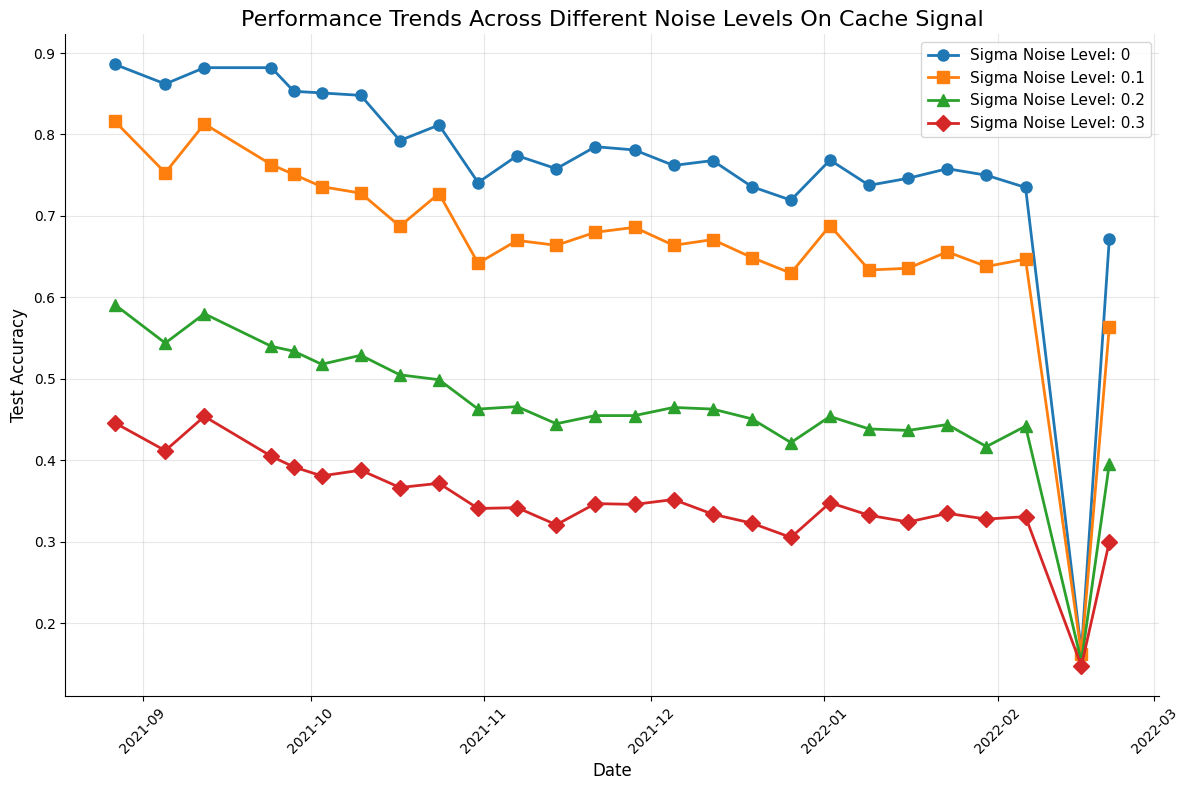

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd


# Convert date strings to datetime objects for proper plotting
def convert_dates(date_dict):
    dates = []
    values = []
    for date_str, value in date_dict.items():
        date_obj = datetime.strptime(date_str, '%Y_%m_%d')
        dates.append(date_obj)
        values.append(float(value))
    return dates, values

# Create the plot
plt.figure(figsize=(12, 8))

# Colors for different trend lines
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'D']

# Plot each trend line
for i, (key, values_dict) in enumerate(results.items()):
    dates, values = convert_dates(values_dict)

    # Plot the data points and line
    plt.plot(dates, values,
             color=colors[i],
             marker=markers[i],
             linewidth=2,
             markersize=8,
             label=f'Sigma Noise Level: {key}')

# Customize the plot
plt.title('Performance Trends Across Different Noise Levels On Cache Signal', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Format x-axis dates
plt.xticks(rotation=45)
plt.tight_layout()

# Add some styling
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()

In [ ]:
path1 = ordered_paths[0] / 'test.h5'
with h5py.File(path1, 'r') as hdf:
  X_test = hdf[f'vector'][:]
  y_test = le.transform((hdf[f'site_name'][:]).reshape(-1,1)).toarray()

In [ ]:
X_test.shape, y_test.shape

((1000, 15000), (1000, 100))

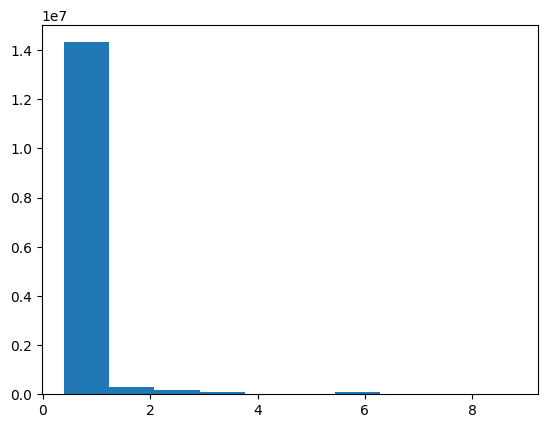

In [ ]:
import matplotlib.pyplot as plt

plt.hist(X_test.reshape(-1))
plt.show()

In [ ]:
X_test.reshape(-1).mean(), np.median(X_test.reshape(-1))

(np.float64(0.6431495518295288), np.float64(0.5))